# Diabetic Foot Ulcer Classification (DFUC)

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## Load Data

In [2]:
# Define Constants
TRAIN_PATH = '../input/diabetic-foot-ulcer-dfu/DFU/Patches'
TEST_PATH = '../input/diabetic-foot-ulcer-dfu/DFU/TestSet'

BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CLASSES = 2
EPOCHS = 200

In [3]:
# Load the Training and Validation Dataset
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'training',
    seed = 0
)

validation_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'validation',
    seed = 0
)

Found 1055 files belonging to 2 classes.
Using 844 files for training.


2021-10-23 05:31:21.610325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Found 1055 files belonging to 2 classes.
Using 211 files for validation.


2021-10-23 05:31:21.694733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 05:31:21.695378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 05:31:21.702683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-23 05:31:21.703427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [4]:
# Load Test Dataset
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

test_ds = tf.data.Dataset.list_files(str(TEST_PATH + '/*'), shuffle=False)
# test_ds = test_ds.shuffle(len(os.listdir(TEST_PATH)), reshuffle_each_iteration=False)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
# Get the class names
class_names = train_ds.class_names
print(class_names)

['Abnormal(Ulcer)', 'Normal(Healthy skin)']


2021-10-23 05:31:24.325706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


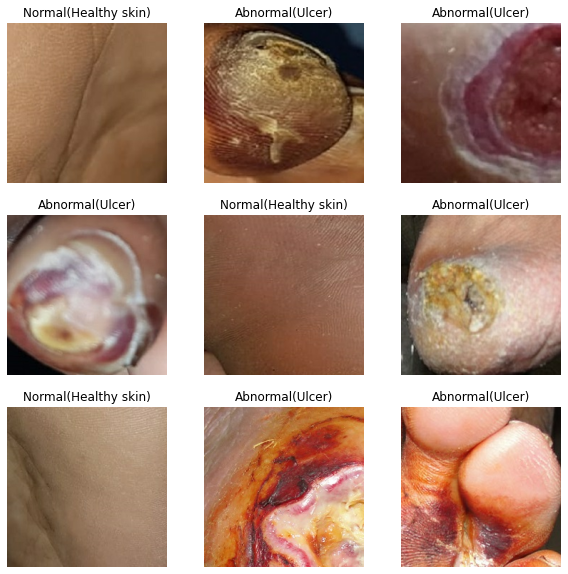

In [6]:
# Visualize the training dataset
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

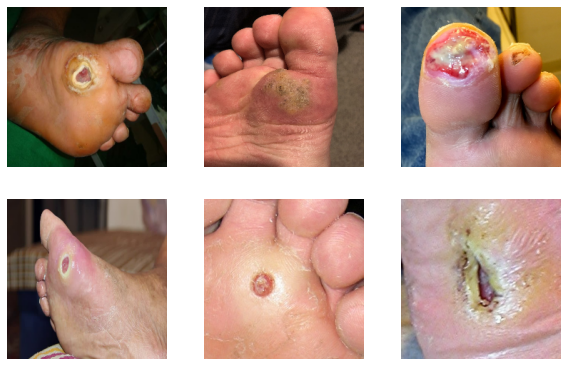

In [7]:
# Visualize the testing dataset
plt.figure(figsize = (10, 10))

i = 0
for images in test_ds.take(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.axis("off")
    i += 1

## Data Augmentation

In [8]:
# Layers of Augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip(),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)

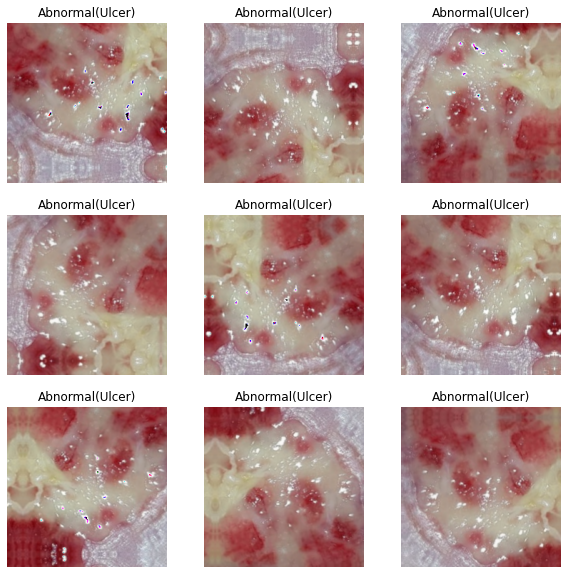

In [9]:
# View the augmentations
plt.figure(figsize = (10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis = 0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [10]:
# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Model

In [11]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8)

In [12]:
# Initialize Model
def build_model():
    inputs = layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = img_augmentation(inputs)
    
    model = EfficientNetB0(include_top = False, weights = 'imagenet', input_tensor = x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation = "sigmoid", name = "pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizers.Adam(learning_rate=1e-3)
    loss = losses.SparseCategoricalCrossentropy()
    model.compile(
        optimizer=optimizer, loss=loss, metrics=["accuracy"]
    )
    
    model.summary()
    
    return model

In [13]:
model = build_model()

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
______________________

## Training

In [14]:
history = model.fit(train_ds, validation_data = validation_ds, 
                    callbacks = [lr_callback, stop_callback],
                    epochs = EPOCHS, verbose = 1)

Epoch 1/200


2021-10-23 05:31:40.726250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 24s 336ms/step - loss: 0.1970 - accuracy: 0.9360 - val_loss: 1.4410 - val_accuracy: 0.6161
Epoch 2/200
27/27 [==============================] - 6s 228ms/step - loss: 0.1248 - accuracy: 0.9633 - val_loss: 2.3952 - val_accuracy: 0.5308
Epoch 3/200
27/27 [==============================] - 6s 227ms/step - loss: 0.0522 - accuracy: 0.9822 - val_loss: 3.8155 - val_accuracy: 0.5261
Epoch 4/200
27/27 [==============================] - 6s 226ms/step - loss: 0.0696 - accuracy: 0.9810 - val_loss: 5.8070 - val_accuracy: 0.6682
Epoch 5/200
27/27 [==============================] - 6s 226ms/step - loss: 0.0299 - accuracy: 0.9929 - val_loss: 3.2747 - val_accuracy: 0.7109
Epoch 6/200
27/27 [==============================] - 6s 228ms/step - loss: 0.0363 - accuracy: 0.9846 - val_loss: 8.8697 - val_accuracy: 0.7156
Epoch 7/200
27/27 [==============================] - 6s 228ms/step - loss: 0.0079 - accuracy: 0.9976 - val_loss: 23.8036 - val_accuracy: 0.6114
Epoch 8/2

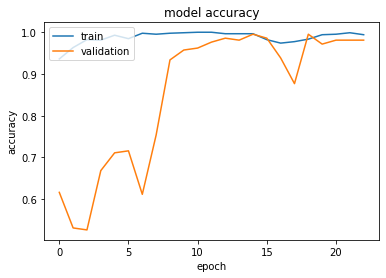

In [15]:
# Plot curves
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

## Prediction

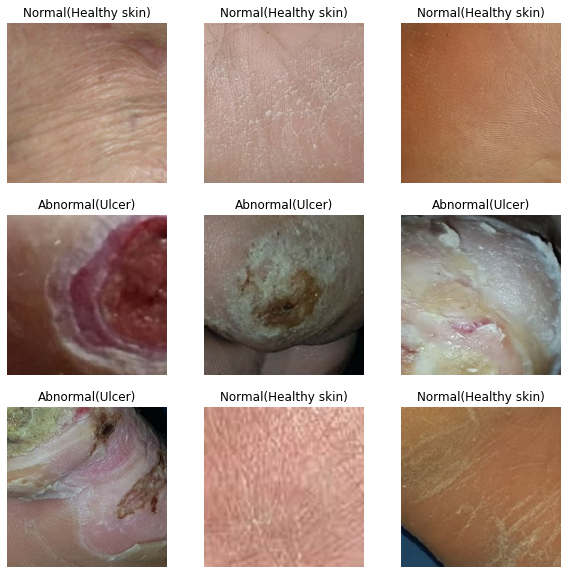

In [16]:
# Testing on Training Set
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        prediction = np.argmax(model.predict(np.array([images[i]])), axis = 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[prediction[0]])
        plt.axis("off")

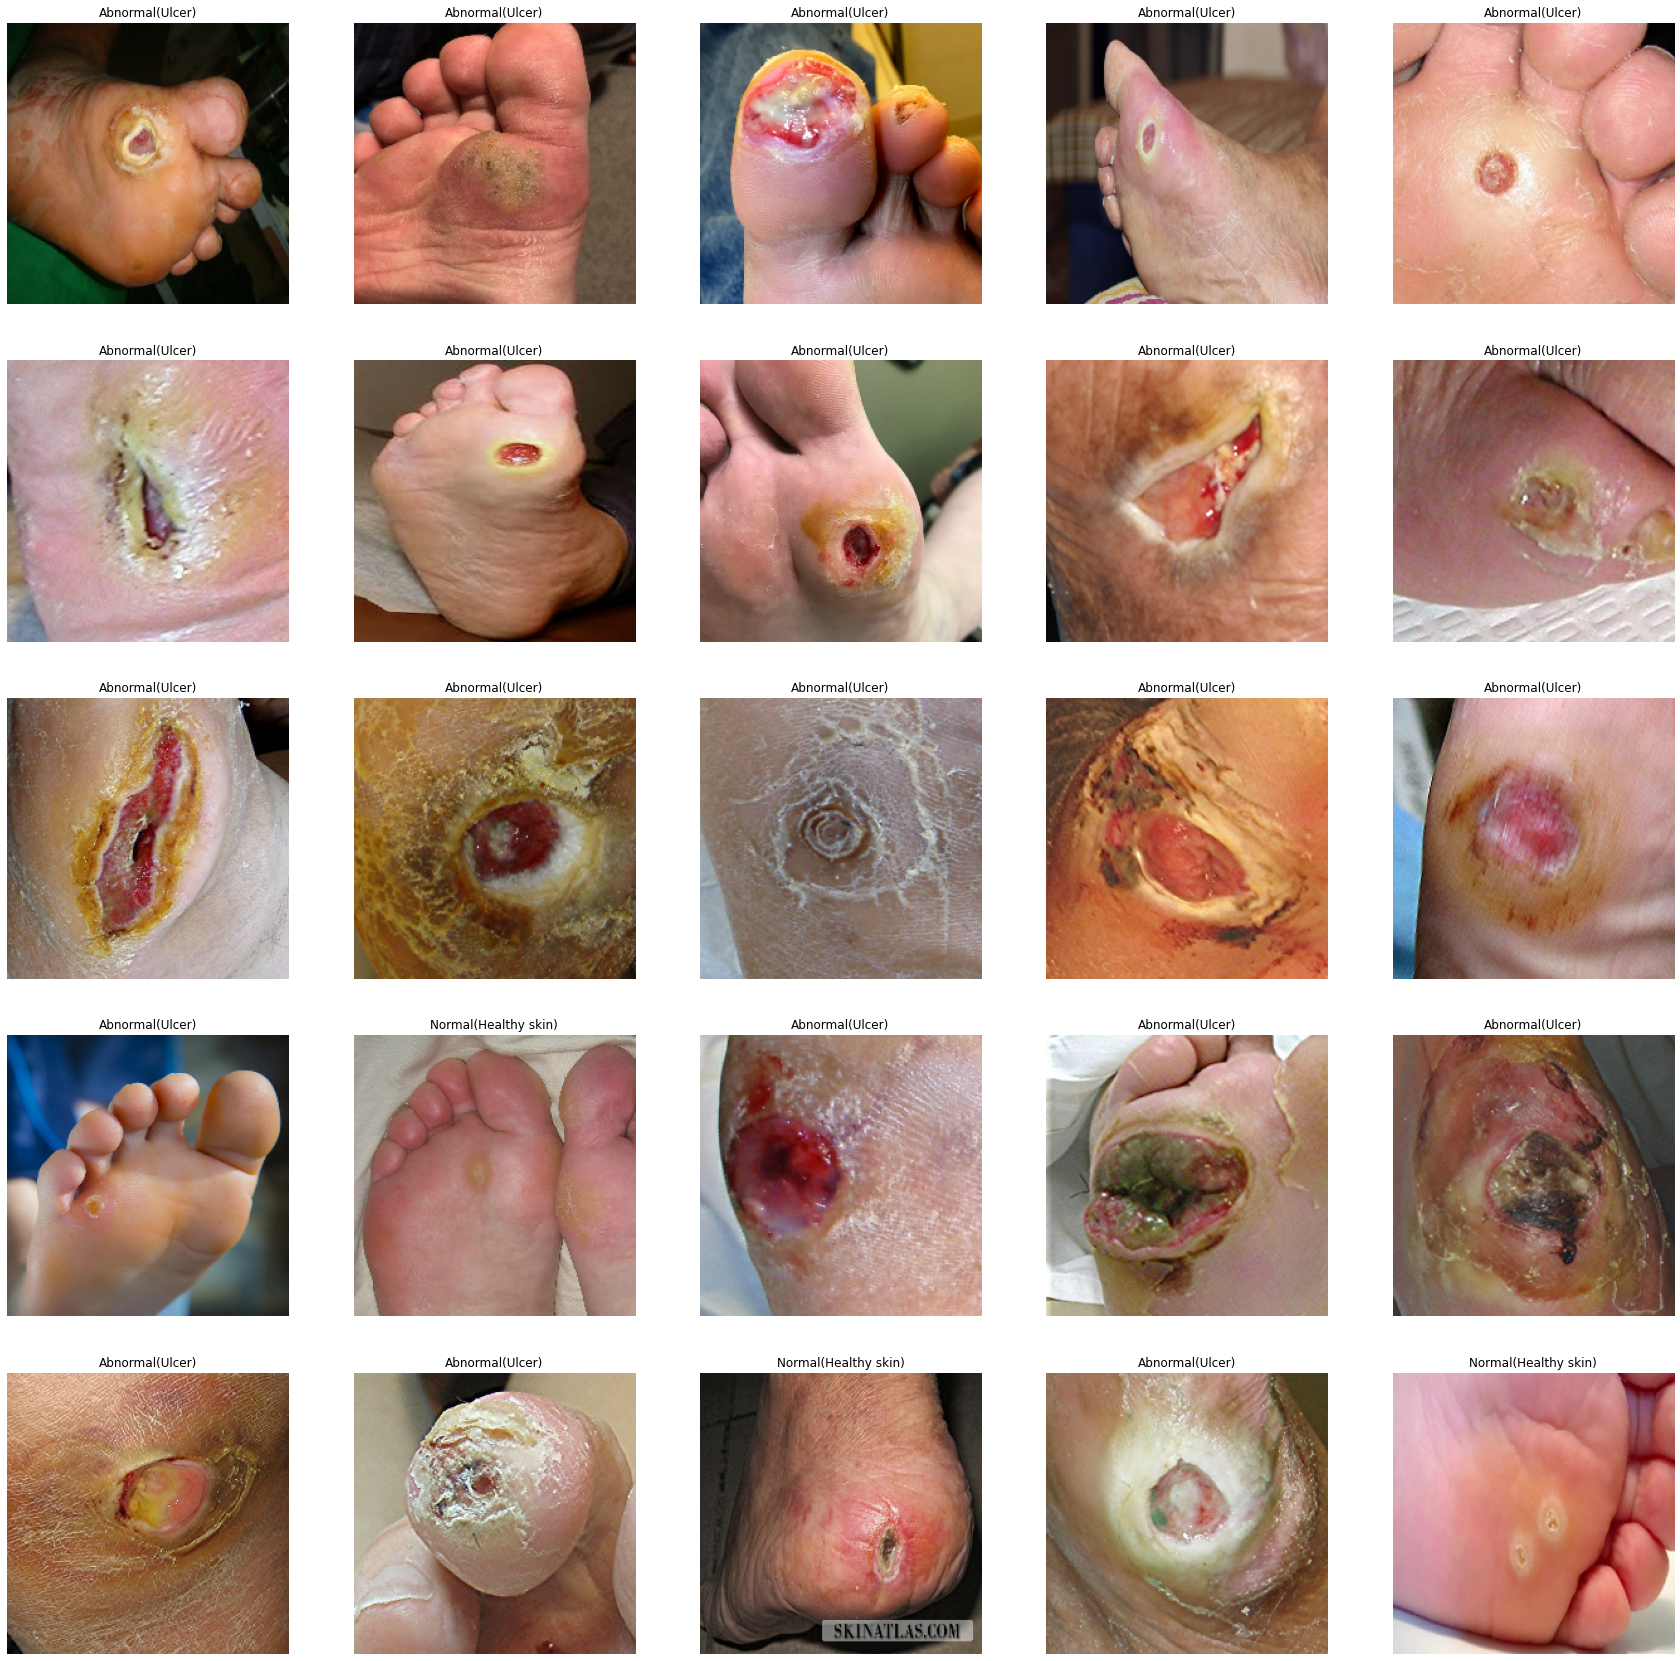

In [17]:
# Testing on Test Set
plt.figure(figsize = (30, 30))
plt.tight_layout()

i = 0
for images in test_ds.take(25):
    ax = plt.subplot(5, 5, i + 1)
    prediction = np.argmax(model.predict(np.array([images])), axis = 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[prediction[0]])
    plt.axis("off")
    
    i += 1